In [1]:
import requests
from urllib.parse import urlencode
import base64
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Connecting to the Spotify API

In [36]:
with open("key.txt", "r") as file:
    secret_key = file.read()

In [37]:
client_id = "d41778f4ffda4294ae57e791c1516468"
client_secret = secret_key

auth_headers = {
    "client_id": client_id,
    "response_type": "code",
    "redirect_uri": "http://localhost:7777/callback",
    "scope": "user-library-read"
}

webbrowser.open("https://accounts.spotify.com/authorize?" + urlencode(auth_headers))

True

## [manual step] Copy this code from the url of the webpage that opens after the code above is executed
TODO can we remove this manual step?

In [11]:
code = "add code from web browser here"

In [12]:
encoded_credentials = base64.b64encode(client_id.encode() + b':' + client_secret.encode()).decode("utf-8")

token_headers = {
    "Authorization": "Basic " + encoded_credentials,
    "Content-Type": "application/x-www-form-urlencoded"
}

token_data = {
    "grant_type": "authorization_code",
    "code": code,
    "redirect_uri": "http://localhost:7777/callback"
}

r = requests.post("https://accounts.spotify.com/api/token", data=token_data, headers=token_headers)

token = r.json()["access_token"]

user_headers = {
    "Authorization": "Bearer " + token,
    "Content-Type": "application/json"
}

# Get my top tracks

In [13]:
user_params = {
    "limit": 50
}
user_tracks_response = requests.get("https://api.spotify.com/v1/me/tracks", params=user_params, headers=user_headers)
tracks = pd.DataFrame(user_tracks_response.json())['items']
track_ids = [pd.DataFrame(tracks[x]).at['id', 'track'] for x in range(len(tracks))]

my_track_features = []
for track_id in track_ids:
    track_features_response = requests.get(f"https://api.spotify.com/v1/audio-features/{track_id}", params=[], headers=user_headers)
    my_track_features.append(track_features_response.json())

# Get the global top tracks

In [14]:
global_top_50 = requests.get(f"https://api.spotify.com/v1/playlists/37i9dQZEVXbMDoHDwVN2tF", params=[], headers=user_headers).json()
tracks = global_top_50['tracks']['items']
[pd.DataFrame(tracks[x]).at['id', 'track'] for x in range(len(tracks))]
global_track_ids = [pd.DataFrame(tracks[x]).at['id', 'track'] for x in range(len(tracks))]


In [15]:
global_track_features = []
for global_track_id in global_track_ids:
    track_features_response = requests.get(f"https://api.spotify.com/v1/audio-features/{global_track_id}", params=[], headers=user_headers)
    global_track_features.append(track_features_response.json())

# Plot differences

In [16]:
feature_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

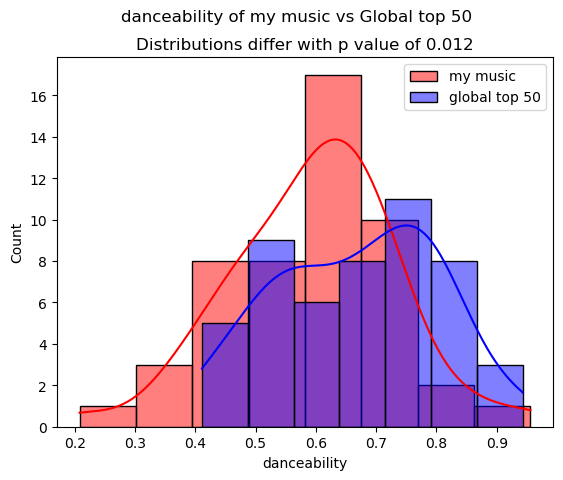

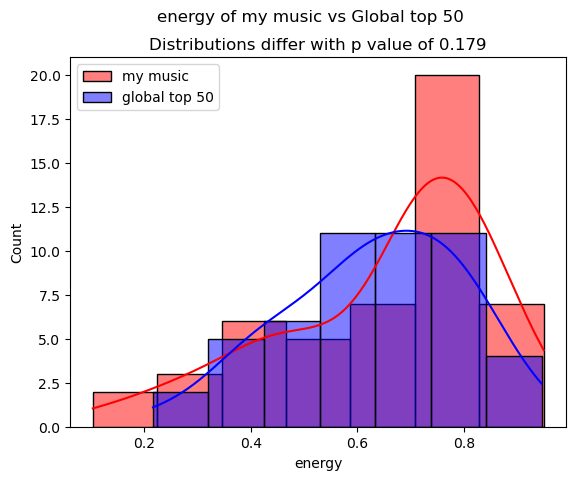

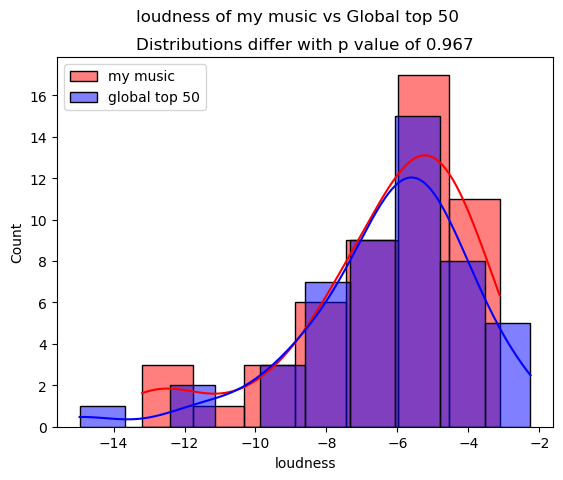

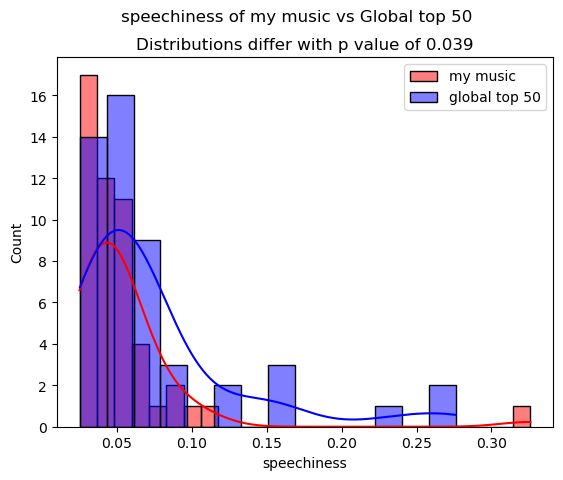

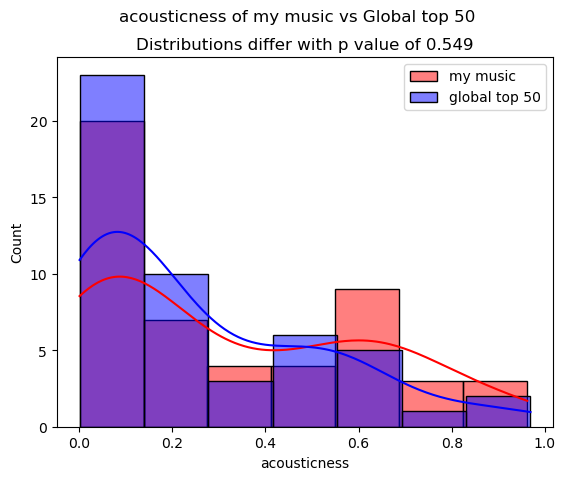

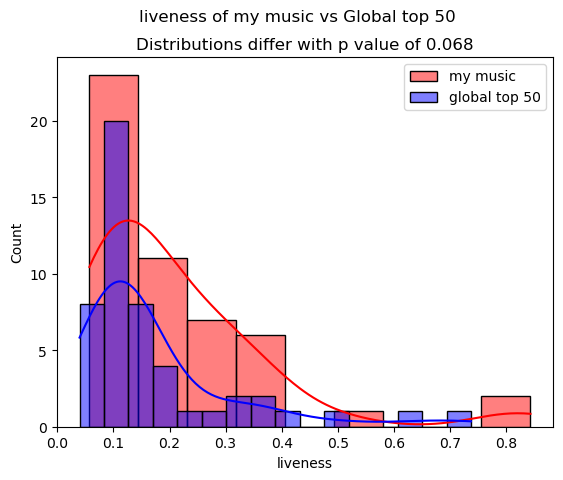

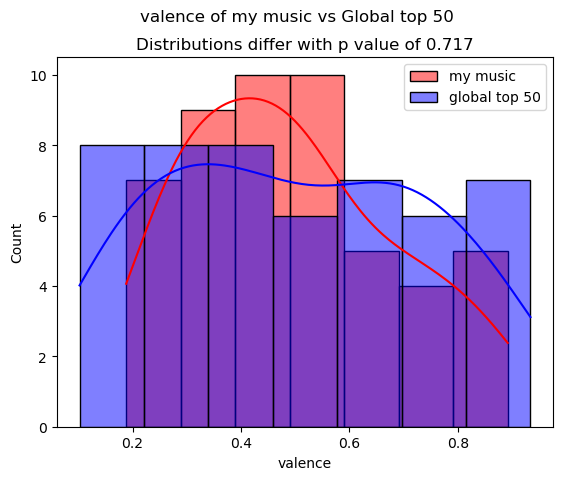

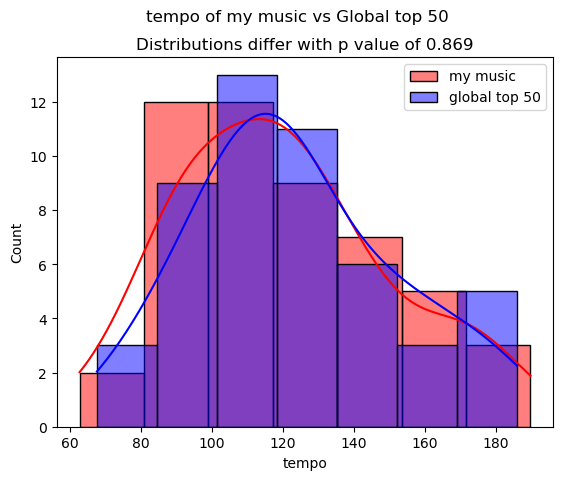

In [17]:
for feature in feature_list:
    plt.figure()
    my_features = [my_track[feature] for my_track in my_track_features]
    global_features = [global_track[feature] for global_track in global_track_features]    
    D, p_value = stats.ks_2samp(my_features, global_features)   
    plt.suptitle(f"{feature} of my music vs Global top 50")
    plt.title(f"Distributions differ with p value of {round(p_value, 3)}")
    sns.histplot(my_features, kde=True, color='red', label='my music')
    sns.histplot(global_features, kde=True, color='blue', label='global top 50')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

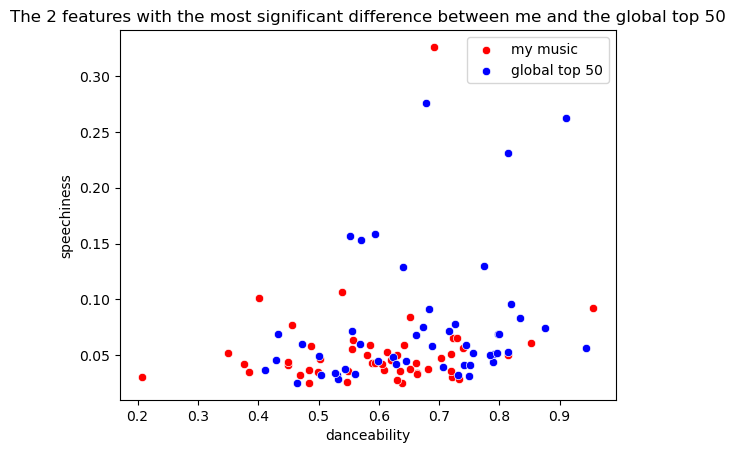

In [33]:
plt.figure()

plt.title('The 2 features with the most significant difference between me and the global top 50')
my_danceabilities = [my_track['danceability'] for my_track in my_track_features]
my_speechiness = [my_track['speechiness'] for my_track in my_track_features]
global_danceabilities = [global_track['danceability'] for global_track in global_track_features] 
global_speechiness = [global_track['speechiness'] for global_track in global_track_features]
sns.scatterplot(x=my_danceabilities, y=my_speechiness, color='red', label='my music')
sns.scatterplot(x=global_danceabilities, y=global_speechiness, color='blue', label='global top 50')
plt.xlabel('danceability')
plt.ylabel('speechiness')
plt.show()